# Downloading Data


To speed up the work the dataset is imported directly from kaggle using user API key and built-in function from *opendatasets* library.

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/competitions/airbus-ship-detection')

# Importing Libraries

In [4]:
import os
import random
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from skimage.io import imread

import tqdm

# Data Overview

In [6]:
submission_sample = pd.read_csv('airbus-ship-detection/sample_submission_v2.csv')
submission_sample.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [7]:
ship_seg = pd.read_csv('airbus-ship-detection/train_ship_segmentations_v2.csv')
ship_seg.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [8]:
train_original = 'airbus-ship-detection/train_v2'

## Images Overview

In [9]:
def get_random_images(folder):
    """Displays a grid of randomly selected images from a specified folder.

    Args:
        folder (str): Path to the directory containing the images.

    Returns:
        None.
    """
    files = os.listdir(folder)
    n_files = len(files)

    random_images = random.sample(files, 16)

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))

    for i, img in enumerate(random_images):
        img = plt.imread(os.path.join(folder, img))
        axes[i // 4, i % 4].imshow(img)

    plt.show()

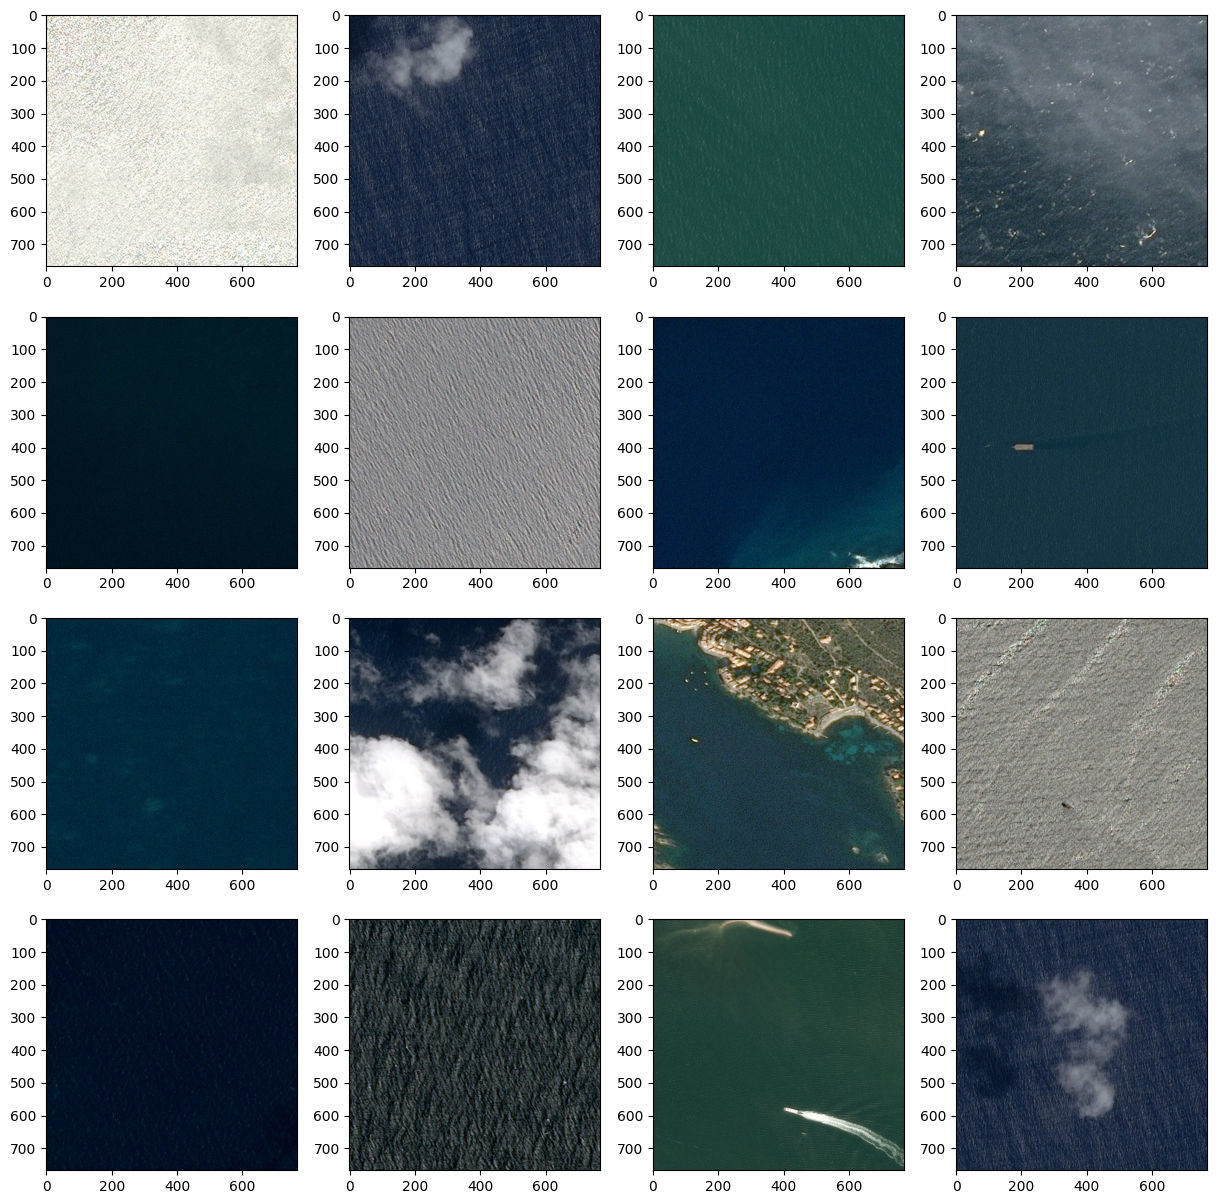

In [10]:
get_random_images(train_original)

Let's get the size of a random train image to understand with which dimension we need to work.

In [11]:
def get_size(path):
    """Calculates the width and height of a randomly selected image in a directory.

    Args:
        path (str): The path to the directory containing images.

    Returns:
        tuple: A tuple containing the width and height of the image.
    """
    random_images = random.sample(os.listdir(path), 1)[0]
    rand_img = Image.open(os.path.join(path, random_images))
    img_width, img_height = rand_img.size

    plt.figure(figsize=(3, 3))
    plt.imshow(rand_img)
    plt.show()

    return img_width, img_height

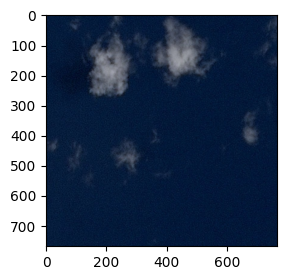

Width: 768
Height: 768


In [12]:
width, height = get_size(train_original)
print(f'Width: {width}')
print(f'Height: {height}')

# Data Preprocessing

Let's compare how much images are described in *ship_seg* dataframe and how much images are in *train_v2* folder.

In [13]:
print('Total number of satellite images in the dataframe:', ship_seg.shape[0])
print('Number of unique satellite images in the dataframe:', ship_seg['ImageId'].unique().shape[0])

Total number of satellite images in the dataframe: 231723
Number of unique satellite images in the dataframe: 192556


In [14]:
print('Total number of satellite images in the train folder:', len(os.listdir(train_original)))

Total number of satellite images in the train folder: 192556


As we can see the total number of images in the dataframe is greater than the unique number of images. This means that some images may have multiple detected ships on them.<br>
Here's the function to group data in the dataframe by 'ImageId'.

In [15]:
def combine_encoded_pixels(df):
    """Groups a dataframe by 'ImageId', combines 'EncodedPixels' with spaces, and resets the index.

    Args:
        df (pd.DataFrame): The input dataframe with columns 'ImageId' and 'EncodedPixels'.

    Returns:
        pd.DataFrame: The grouped dataframe with combined 'EncodedPixels'.
    """
    df['EncodedPixels'] = df['EncodedPixels'].astype(str)

    return df.groupby('ImageId')['EncodedPixels'].apply(' '.join).reset_index()

In [16]:
seg_pixels = combine_encoded_pixels(ship_seg)
print("Updated dataframe shape is", seg_pixels.shape)

Updated dataframe shape is (192556, 2)


The images have to be resized to the size (256, 256, 3) to train the model.

In [17]:
def resize_images(input_folder_path, output_folder_path, image_size=256):
    """Resizes all images in a folder and its subfolders to the specified size.

    Args:
        input_folder_path (str): Path to the folder containing images.
        output_folder_path (str): Path to the output folder where resized images will be saved.
        image_size (int, optional): Desired width and height of the resized images. Defaults to 256.

    Returns:
        None.
    """
    if os.path.exists(output_folder_path):
        print(f"Output folder '{output_folder_path}' already exists. Images will be saved there.")
    else:
        os.makedirs(output_folder_path)

    with tqdm.tqdm(total=len(os.listdir(input_folder_path)), desc="Resizing Images") as pbar:
        for filename in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, filename)
            output_image_path = os.path.join(output_folder_path, filename)
    
            image = Image.open(input_image_path)
            resized_image = image.resize((image_size, image_size), Image.LANCZOS)
            resized_image.save(output_image_path)
            pbar.update()

In [18]:
images = 'data/train'

In [19]:
IMG_SIZE = (256, 256, 3)

In [21]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
resize_images(train_original, images, IMG_SIZE[0])

# Data Creation for Training

To learn model to detect ships the images masks have to be created. 

In [ ]:
def create_masks(image_folder, data_frame, mask_folder, target_size=(256, 256)):
    """Creates masks for train images based on ship information in the dataframe,
    resizes to the specified target size.

    Args:
        image_folder (str): Path to the folder containing ship images.
        data_frame (pd.DataFrame): Dataframe with 'ImageId' and 'EncodedPixels' columns.
        mask_folder (str): Path to the folder for saving masks.
        target_size (tuple, optional): Target size for resizing masks. Defaults to (256, 256).
    """

    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)

    with tqdm.tqdm(total=len(data_frame), desc="Creating Masks") as pbar:
        for row in data_frame.itertuples():
            image_id = row.ImageId
            image_path = os.path.join(image_folder, image_id)
            mask_path = os.path.join(mask_folder, f"{image_id}_mask.jpg")

            image = imread(image_path)

            mask = np.zeros((image.shape[:2]), dtype=np.uint8)

            if row.EncodedPixels == 'nan':
                resized_mask = cv2.resize(mask, target_size)
                cv2.imwrite(mask_path, resized_mask)
                pbar.update()
                continue

            pixel_values = [int(val) for val in row.EncodedPixels.split(' ')]
            for i in range(0, len(pixel_values), 2):
                start_pixel = pixel_values[i] - 1
                run_length = pixel_values[i + 1]
                mask[(start_pixel // width):(start_pixel // width + run_length),
                     start_pixel % width:(start_pixel % width + run_length)] = 255

            mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
            mask = cv2.flip(mask, 1)
            resized_mask = cv2.resize(mask, target_size)

            cv2.imwrite(mask_path, resized_mask)
            pbar.update()

In [ ]:
masks = 'data/masks'

In [ ]:
create_masks(images, seg_pixels, masks)

Checking the validity of created masks.

In [ ]:
print('Number of created masks:', len(os.listdir(masks)))

In [ ]:
get_random_images(masks)

In [ ]:
width, height = get_size(masks)
print(f'Width: {width}')
print(f'Height: {height}')